In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [153]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix
import pywt
from scipy.sparse.linalg import LinearOperator, cg

In [4]:
# Load the MATLAB file
mat = scipy.io.loadmat('image_xyt.mat')

In [5]:
image=mat['image_xyt']

In [6]:
#function to display random images
def display_random_images(image: np.array,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(image.shape[-1]), k=n)

    # 5. Setup plot
    plt.figure(figsize=(60, 60))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image = image[:,:,targ_sample]
        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image,cmap='gray')
        plt.axis("off")
        plt.title(f'Frame No:{targ_sample}',fontsize=25)

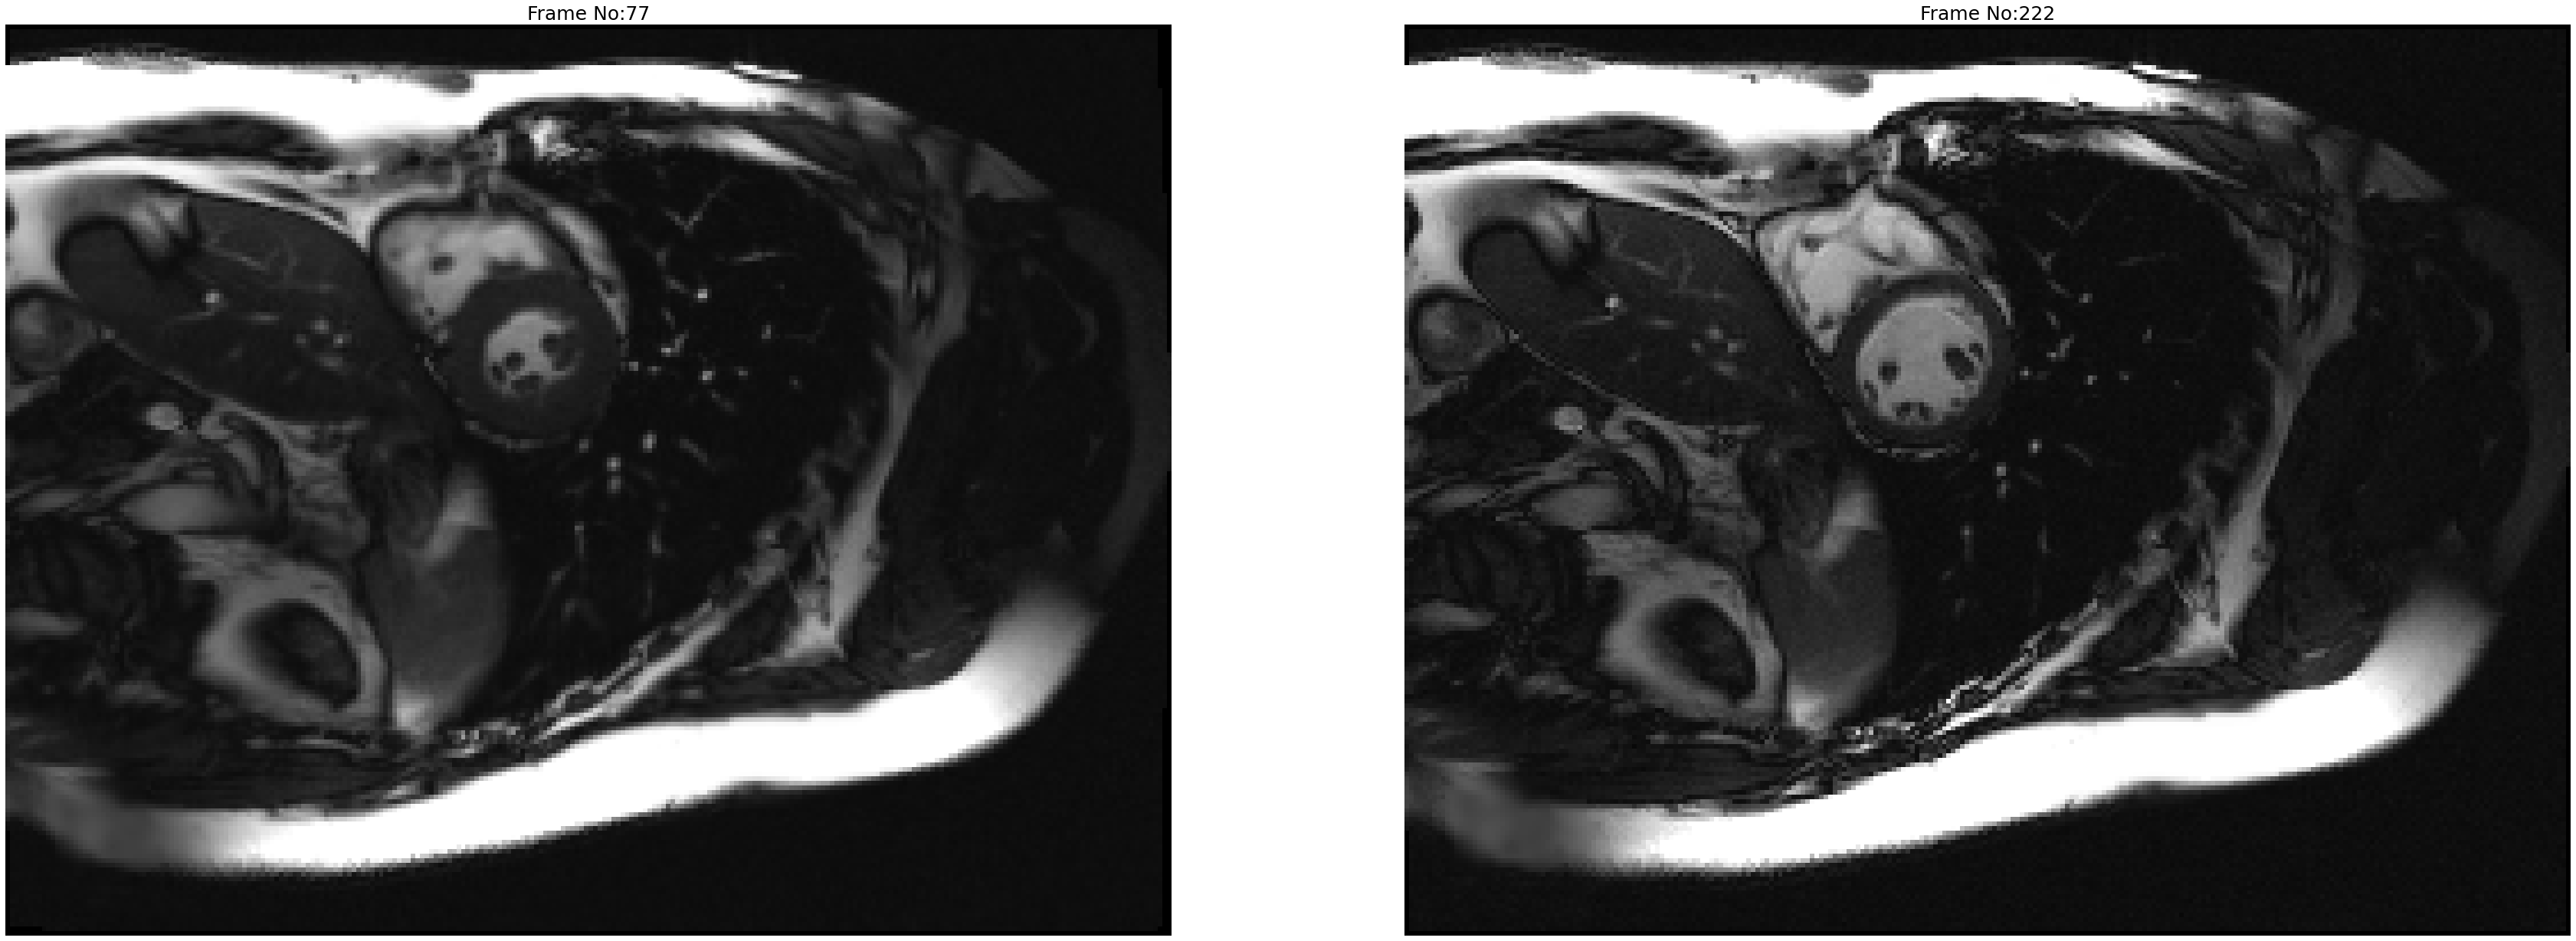

In [7]:
display_random_images(image,n=2)

In [10]:
# defines varibles
#Np: number of phase encodings
Np=image.shape[0]
#number of frequence encodings
Nf= image.shape[1]

#number of frames
Nfr=256
#Nnav: Number of navigator lines
Nnav  = 4;

In [12]:
#  form the k-t space sampling mask 
# Nsam number of sample in k space
Nsam = 32
#nav_ind: A vector containing the indices for navigator lines.
nav_ind = list(range(int(Np/2-Nnav/2),int(Np/2+Nnav/2)))

In [16]:
def tem_sampling_generation(Np, Nfr, Nnav, Nsam):
    """
    Generating the temporal sampling mask.
    
    Inputs:
    Np: number of phase encodings
    Nfr: number of temporal frames
    Nnav: number of phase encodings for navigator signal
    Nsam: number of samples acquired at each k-space location
    
    Output:
    temmask: temporal sampling mask
    """

    temmask = np.zeros((Np, Nfr))
    nav_ind = np.arange(Np // 2 - Nnav // 2, Np // 2 + Nnav // 2)

    for ii in range(Np):
        if ii in nav_ind:
            temmask[ii, :] = np.ones(Nfr)
        else:
            temp = np.zeros(Nfr)
            ind = np.random.permutation(Nfr)
            temp[ind[:Nsam]] = 1
            temmask[ii, :] = temp

    temmask = temmask.astype(bool)
    return temmask

In [38]:
Kraw = 1 / np.sqrt(Np * Nf) * np.fft.fft2(image, axes=(1, 0))

image_xyt = np.reshape(image, (Np * Nf, Nfr), order='F')
Kraw_C = np.reshape(Kraw, (Np * Nf, Nfr), order='F')

In [17]:
temmask=tem_sampling_generation(Np,image.shape[-1],Nnav, Nsam)
temmask=np.fft.fftshift(temmask,axes=0)

In [24]:
Mask = np.tile(temmask, (1, Nf)).reshape(Np, Nfr, Nf, order='F')
Mask = np.transpose(Mask, axes=(0, 2, 1))
Mask=np.reshape(Mask,(Np*Nf, Nfr),order='F')

In [47]:
d = Kraw_C.T[Mask.T]

In [51]:
nav_location = np.zeros((Np, 1))
nav_location[nav_ind] = 1

In [53]:
fftshift_nav_location = np.fft.fftshift(nav_location, axes=0)
indices = np.where(fftshift_nav_location)
Navdata = Kraw[indices[0], :, :].reshape(Nnav * Nf, Nfr, order='F')

In [72]:
Navdata

array([[ 0.01863807+0.j        ,  0.01862001+0.j        ,
         0.01862923+0.j        , ...,  0.01850338+0.j        ,
         0.01851466+0.j        ,  0.01852505+0.j        ],
       [ 0.00381688+0.00130866j,  0.00382665+0.00132385j,
         0.00383517+0.00134973j, ...,  0.00382924+0.00138567j,
         0.00382703+0.00139601j,  0.00381846+0.00139416j],
       [-0.00248823+0.00103277j, -0.00248228+0.00102038j,
        -0.00248152+0.00103118j, ..., -0.00242107+0.00107627j,
        -0.00242487+0.00108661j, -0.00243573+0.00109205j],
       ...,
       [ 0.00156735+0.00051847j,  0.00156277+0.00051678j,
         0.00155341+0.00050441j, ...,  0.00147594+0.0004871j ,
         0.00147747+0.00047971j,  0.00148633+0.00048383j],
       [ 0.00048731+0.0031826j ,  0.00048108+0.00318471j,
         0.00048373+0.00317959j, ...,  0.00043185+0.00318874j,
         0.00042901+0.00318322j,  0.00043249+0.00317521j],
       [-0.00332419+0.00311322j, -0.00332022+0.00311574j,
        -0.00330172+0.00312865

In [84]:
# Set the random seed for reproducible results
np.random.seed(42)
r = 32
_, _, Vt_r = np.linalg.svd(Navdata, r)
Vt_r=-Vt_r[:r,:]

In [86]:
beta = 1e3
mu   = 2.5e-6

In [87]:
Us_r0 = np.zeros((Np * Nf, r))

In [88]:
def ps_sparse_recon(d,
                   M,
                   Us_r,
                   Vt_r,
                   mu: float,
                   beta: float,
                   regularizer: str,
                   Np: int,
                   Nf: int,
                   Nfr: int):
    '''This code performs image reconstruction from highly undersampled data using
    joint partial separability (PS) and sparsity constraints
    
    Args:
        d: measured data undersampled  Size([1867776, 1])
        Mask: k-t space sampling mask Size([51200, 256])
        Us_r: initial value of Us_r Size([51200, 32])
        Vt_r: basis for the temporal subspace Size([32, 256])
        mu: regularization parameter 
        beta: initial value of continuation parameter
        regularizer: spa_reg for spatial sparsity regularization
        Np: number of phase encodings
        Nf: number of frequence encodings
        Nfr: number of temporal frames
    Return:
        Us_r: basis for the spatial subspace
    '''
    #tolerance for error
    tol = 1e-5
    #maximum number of iterations
    maxit = 200
    # size of temporal basis
    r= Us_r.shape[-1]
    # get the rows and column index of the non-zero mask
    Cind,Rind  = np.nonzero(Mask.T)
    # Create a sparse matrix and multiply it with Vt_r'
    bb = coo_matrix((d, (Rind, Cind)), shape=(Np * Nf, Nfr)) @ Vt_r.T
    
    Uk_r = (1 / np.sqrt(Np * Nf)) * np.fft.fft2(Us_r.reshape(Np, Nf, r), axes=(1, 0)).reshape(Np * Nf, r, order='F')
    Us_r_last=Us_r
    
    Vf_r = 1/np.sqrt(Nfr) * np.fft.fft(Vt_r, axis=1)
    #outer loop
    for i in range(0,5):
        print(f"The outerloop loop is {i}")
        for j in range(0,100):
            print(f"The inner loop is {j}")
            product = Us_r0 @ Vf_r
            sign = np.sign(product)
            thresholded = pywt.threshold(product, 1 / beta, mode='soft')
            Gs = sign * thresholded @ Vf_r.T
            

In [140]:
Cind,Rind  = np.nonzero(Mask.T)

In [141]:
# Create a sparse matrix and multiply it with Vt_r'
bb = coo_matrix((d, (Rind, Cind)), shape=(Np * Nf, Nfr)) @ Vt_r.T

In [97]:
Uk_r = (1 / np.sqrt(Np * Nf)) * np.fft.fft2(Us_r0.reshape(Np, Nf, r), axes=(1, 0)).reshape(Np * Nf, r, order='F')

In [120]:
Vf_r = 1/np.sqrt(Nfr) * np.fft.fft(Vt_r, axis=1)

In [130]:
product = Us_r0 @ Vf_r
sign = np.sign(product)
thresholded = pywt.threshold(np.abs(product), 1 / beta, mode='soft')
Gs = sign * thresholded @ Vf_r.T

In [133]:
Gk=(1 / np.sqrt(Np * Nf))*np.fft.fft2((np.reshape(Gs,(Np,Nf,r),order='F')),axes=(1,0))

In [145]:
b = bb + mu * beta / 2 * np.reshape(Gk, (Np * Nf, r), order='F')

In [160]:
#tolerance for error
tol = 1e-5
#maximum number of iterations
maxit = 200

In [206]:
# Define the normal_oper function (using the provided implementation)
def normal_oper(Uk_r, Vt_r, Rind, Cind, Mask):
    N = Mask.shape[0]
    M = Mask.shape[1]
    r = Vt_r.shape[0]
    G = np.reshape(Uk_r, (N, r),order='F') @ Vt_r
    d = G.T[Mask.T]
    print(d)
    UU = coo_matrix((d, (Rind, Cind)), shape=(N, M)) @ Vt_r.T
    UU = np.reshape(UU, (N * r,),order='F')
    return UU

In [207]:
# Define a linear operator for the matrix-vector multiplication
def funcd(x):
    result = normal_oper(x, Vt_r, Rind, Cind, Mask) + mu * beta / 2 * x
    return result

In [208]:
A = LinearOperator((len(b)*r,len(b)*r), matvec=funcd)

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


In [189]:
# Solve the linear system using the PCG method
solution, info = cg(A, b.ravel(), tol=tol, maxiter=500, x0=Uk_r.ravel())

In [190]:
solution

array([ 1.72337596e+05+20801.62404929j, -3.07840490e+01  -137.24511483j,
       -2.09311789e+03 -4772.28679879j, ...,
       -9.23859210e+01   +45.72924338j, -2.00518013e+01  +204.70303295j,
        1.14076296e+02   -61.46924698j])

In [201]:
# Compute Ax using the solution vector x
Ax = funcd(solution)

# Calculate the residual and its norm
residual = Ax - b.ravel(order='F')
residual_norm = np.linalg.norm(residual)

# Print the residual and its norm
print("Residual:", residual)
print("Residual norm:", residual_norm)

Residual: [ 1.72553129e+05+2.06403485e+04j -3.26263783e+01-1.37304585e+02j
 -5.79217302e+01-2.60242353e+02j ...  5.91580652e+00-8.58473355e+00j
 -7.37990819e+01-1.60334203e+02j -3.79531497e+01+1.26965242e+02j]
Residual norm: 768313.9763186212


In [202]:
2*Ax

array([ 3.45106847e+05+4.12806967e+04j, -6.51311555e+01-2.74564374e+02j,
       -1.15852980e+02-5.20489221e+02j, ...,
        1.18307418e+01-1.71695176e+01j, -1.47598122e+02-3.20668409e+02j,
       -7.59062974e+01+2.53930507e+02j])

In [204]:
b.ravel(order='F')

array([ 2.94762785e-01-1.52114523e-04j,  6.08005788e-02+2.23984947e-02j,
       -4.75968852e-03-2.25780924e-03j, ...,
       -4.35593069e-04-2.52327425e-05j,  2.09595161e-05-1.44641761e-06j,
        9.66817483e-07+1.21521032e-05j])

In [205]:
Uk_r

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])